In [2]:
#!pip install numba
import numpy as np
import matplotlib.pyplot as plt 
import random
import numba as nb
from numba import jit 
plt.rc('font', size=20) # makes the fonts used in graphs a bit larger (and clearer)!

## Bayesian inference in data science

The purpose of stochastic calculation is usually to calculate integrals (averages) with respect to a target distribution. We shall look at an application for this in Bayesian inference for Gaussian mixture models.  This discussion is very compressed. For a more in-depth (but still very readable) look at Bayesian inference in mixture models, see Ref [1] below.

We will look at one example for inferring a statistical property from data via sampling.

Let's assume there are three types of data mixed together: A, B and C. For concreteness, you could suppose that we have combined three data sets containing mean August high temperatures from three cities at different latitudes which are assumed to be modelled by Gaussian distributions, let us say A = Helsinki, B= Ulan Bator, C = Buenos Aires.  For each city we have a mean and a standard deviation of the corresponding Gaussian.   

If we combine datasets of equal size of August high temperatures from the three cities, we may make the natural ansatz that that any given datum $y$ is modelled by the _probability distribution_ $\hat{\rho}$ of $y$ whose density is just the sum of the three Gaussians.  To simplify things we will further assume in the following that all three of the standard deviations are 3C,  whereas the mean temperatures are unknown.

$$ \hat{\rho}(y\,|\,\mu_A,\mu_B,\mu_C) \propto \exp({-(y-\mu_A)^2/18}) + \exp({-(y-\mu_B)^2/18}) + \exp({-(y-\mu_C)^2}/18)$$

The "18" in each denominator is just $2\sigma^2$, where $\sigma=3$ for each component.

If we know the values of $\mu_A,\,\mu_B$ and $\mu_C$ then we can determine the likelihood of a given temperature coming from the mixture using the above formula. But what if we have the data, and just know there are three cities, but we don't know the three mean temperatures? We can use Bayes theorem to infer them.  That is, we can find the probability distribution for the centres given the data. 

If we have a set of $N$ datapoints $Y = \{y_i\}$, then we can write the distribution for the centres as 

$$ \rho(\mu_A,\mu_B,\mu_C\,|\,Y) \propto  \rho_\text{prior}(\mu_A,\mu_B,\mu_C) \prod_{i=1}^N \hat{\rho}(y_i\,|\,\mu_A,\mu_B,\mu_C),$$
where $\rho_\text{prior}$ is the _prior_ which regularizes the combined distribution, and $\hat{\rho}$ is the _likelihood_ defined above.

The simplest approach to studying the Bayesian model would be to use an 'expectation maximization' method which involves finding the mode (or modes, in this case) of the distribution by maximizing the density.  We will look at a more nuanced method that 
instead explores the probability distribution $\rho$ for the means given some temperature data $Y$. 

The distribution $\rho$ looks very different to the previous distributions we have seen, as there is no potential energy $U(q)$. We will think of $q=[\mu_A,\mu_B,\mu_C]$ and as we can write $\rho(q) = \exp(-\log(\rho(q)))$ we can then think of an effective potential $U(q) = -\log(\rho(q))$.

Thus we have 

$$ U(\mu_A,\mu_B,\mu_C) = -\log( \rho_\text{prior}(\mu_A,\mu_B,\mu_C) ) - \sum_{i=1}^N \log( \hat{\rho}(y_i\,|\,\mu_A,\mu_B,\mu_C) )$$


In data science and statistics, $U$ is called the negative _log-posterior_ instead of the energy.


Ref [1]: http://www.cs.toronto.edu/~rgrosse/csc321/mixture_models.pdf

In [3]:
file_object = open('temperatures.npy', 'rb')
Y= np.load(file_object)
type(Y)

numpy.ndarray

In [4]:
Y.shape

(300,)

And then we can make a histogram to look at the distribution of the data:

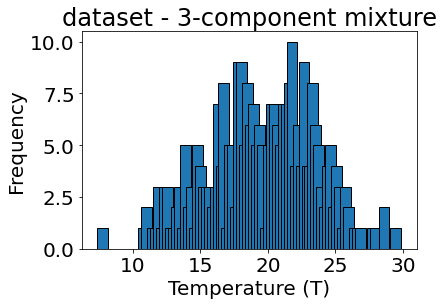

In [5]:
histogram,bins = np.histogram(Y,bins=100)
mid_bins = (bins[:-1]+bins[1:])/2
plt.bar(mid_bins,histogram,edgecolor='k')
plt.xlabel('Temperature (T)')
plt.ylabel('Frequency')
plt.title('dataset - 3-component mixture')
plt.show()

As we can see here, the temperatures look a bit of a mess, with some low values, even down to under 10 and some high values up to about 30.  The next challenge is to unravel this mess and figure out what the temperatures are for the three cities.  Can you guess this from the above picture?  If you can you are a statistical genius!   It is not at all obvious what the three temperature are.  (...and no peaking using google!)

We shall use a Gaussian prior with a large variance, just to keep us from sampling e.g. negative numbers. We will put the centre of the prior at 20, which is roughly the mean of the data.  Let us take $\sigma =10$  for each of the three means in the prior.

$$ \rho_\text{prior}(\mu_A,\mu_B,\mu_C) \propto \exp({-(20-\mu_A)^2/200}) \exp({-(20-\mu_B)^2/200}) \exp({-(20-\mu_B)^2/200}) $$

In [6]:
@jit(nopython=True)
def force(q,y,a,b,c):
    m1,m2,m3 = q 
    
    # write code to compute the three components of the force vector, as well
    # as the potential (by calling the U function above)
    
    g1 = np.exp(-(y-m1)**2/18) 
    g2 = np.exp(-(y-m2)**2/18)
    g3 = np.exp(-(y-m3)**2/18)
    
    u = -np.sum( np.log(g1+g2+g3) )
    u = u + (m1-20)**2/200
    u = u + (m2-20)**2/200
    u = u + (m3-20)**2/200 
    
    f1 =  -np.sum(g1 * (m1-y)/9/ (g1+g2+g3) ) - (m1-20)/100 + a*np.random.normal(0,1,1) 
    f2 =  -np.sum(g2 * (m2-y)/9/ (g1+g2+g3) ) - (m2-20)/100 + b*np.random.normal(0,1,1) 
    f3 =  -np.sum(g3 * (m3-y)/9/ (g1+g2+g3) ) - (m3-20)/100 + c*np.random.normal(0,1,1)
    
    return u, f1,f2,f3

In [7]:
## 16,20,22
@jit(nopython=True)
def run_sim(y,a,b,c,q00,q10,q20,lr,steps):
        p1 = np.random.randn(1)
        p2 = np.random.randn(1)
        p3 = np.random.randn(1)

        q1 = q00 + 2*np.random.randn(1)
        q2 = q10 + 2*np.random.randn(1)
        q3 = q20 + 2*np.random.randn(1)

        h = lr 
        Q1 = [] 
              
        
        f1_1 = []
        f2_1 = []
        f3_1 = []
        
        gamma =0.5
        beta = 1

        c1 = np.exp(-h*gamma)
        c3 = np.sqrt(1-c1*c1)*np.sqrt(1/beta)
        pe,f1_12,f2_12,f3_12 = force([q1,q2,q3],y,a,b,c)
        f1_1.append(f1_12)
        f2_1.append(f2_12)
        f3_1.append(f3_12)

        for ii in range(steps):

            # B
            p1 = p1 + (h/2)*f1_12
            p2 = p2 + (h/2)*f2_12
            p3 = p3 + (h/2)*f3_12

            # A
            q1 = q1 + (h/2)*p1
            q2 = q2 + (h/2)*p2
            q3 = q3 + (h/2)*p3

            # O
            p1 = c1*p1 + c3*np.random.randn(1)
            p2 = c1*p2 + c3*np.random.randn(1)
            p3 = c1*p3 + c3*np.random.randn(1) 

            # A
            q1 = q1 + (h/2)*p1
            q2 = q2 + (h/2)*p2
            q3 = q3 + (h/2)*p3

            pe,f1_12,f2_12,f3_12 = force([q1,q2,q3],y,a,b,c)
            f1_1.append(f1_12)
            f2_1.append(f2_12)
            f3_1.append(f3_12)

            # B 
            p1 = p1 + (h/2)*f1_12
            p2 = p2 + (h/2)*f2_12
            p3 = p3 + (h/2)*f3_12

            ke = p1**2 + p2**2 + p3**2
            ke = ke / 2

            qqq1 = [q1,q2,q3].copy()
            Q1.append(qqq1)
            
            qqq2 = [q2-q1,2*q3-q2-q1]
            
        return Q1, f1_1, f2_1, f3_1
       

Mean values: [16.071621673552567, 20.61754656436608, 21.928664790490966]
Standard deviations: [0.418222755264849, 0.5781415345721495, 0.4815375519913634]


Mean values: [12.118707321602153, 18.541416008064946, 26.155140449722566]
Standard deviations: [5.548997021796231, 4.605068677656041, 6.631685607107198]


Mean values: [0.005613346213018762, 0.00042621909400679603, -0.005848508674715357]
Standard deviations: [2.2090087955557642, 2.1705428040345383, 2.305142041870949]


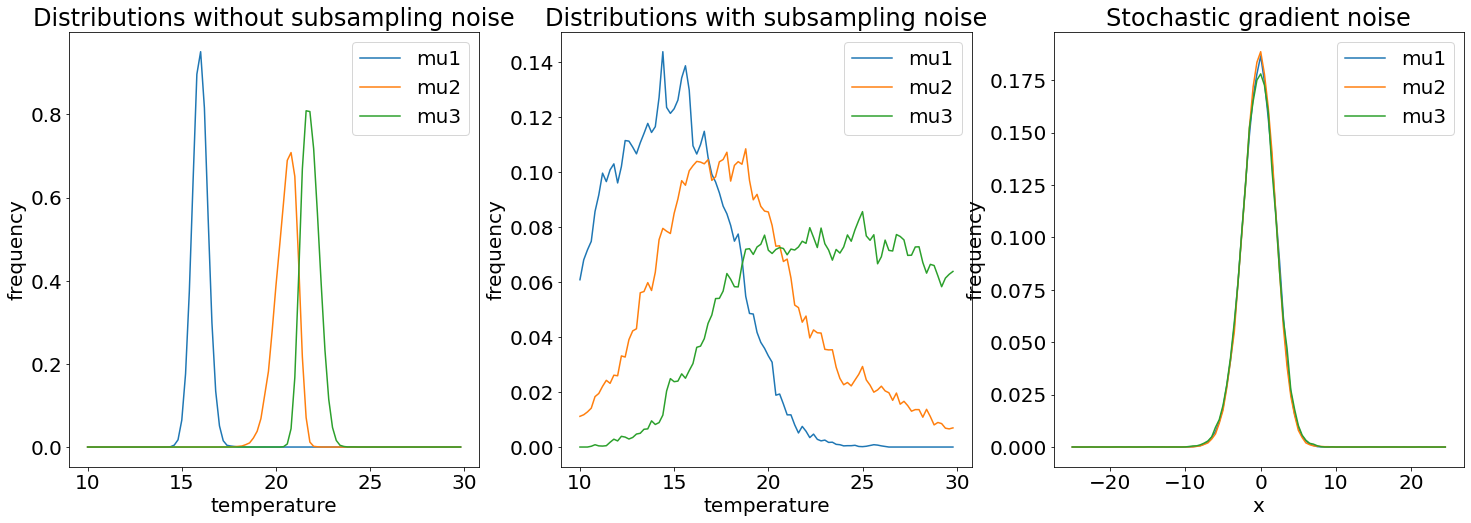

Mean values: [16.070021688348906, 20.620053956437243, 21.929712712505633]
Standard deviations: [0.4129718618923726, 0.5799525016786183, 0.47600097697351546]


Mean values: [9.879502962526885, 16.80631577771716, 22.661799027666518]
Standard deviations: [3.638657803772363, 3.044561947713863, 3.664131791945258]


Mean values: [0.03064640015893414, -0.025724500332050995, -0.007383768544489943]
Standard deviations: [2.229249472872375, 2.153694974411736, 2.320472927714073]


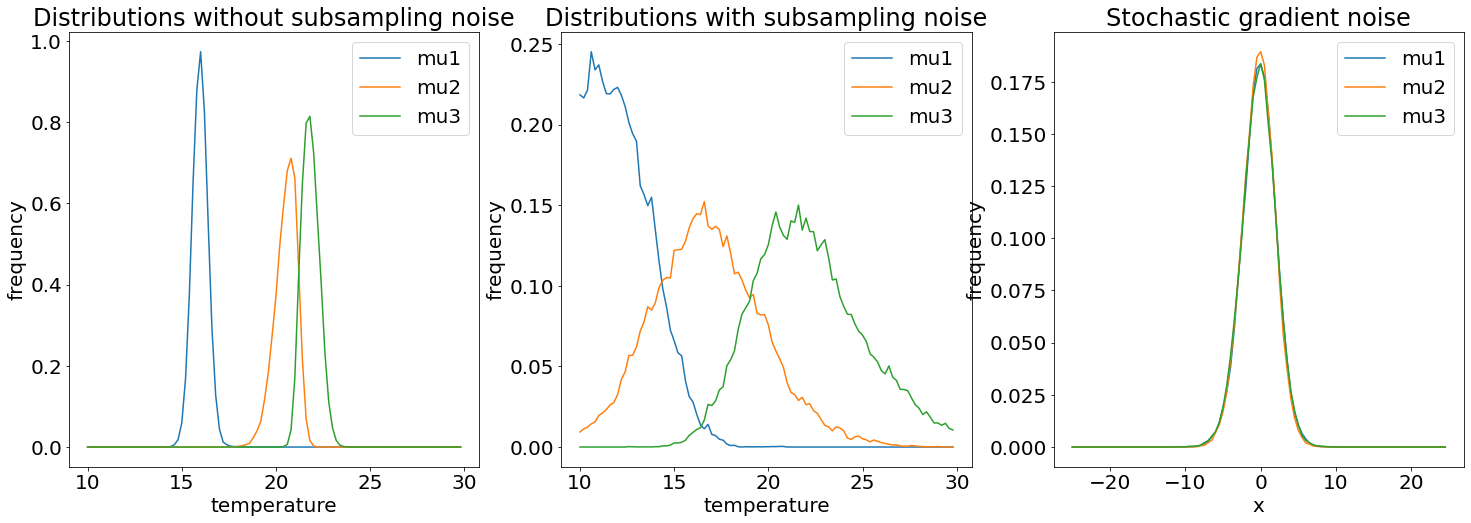

Mean values: [16.07418491008143, 20.617580070031114, 22.0017124675202]
Standard deviations: [0.4250901456500327, 0.5894851804034131, 1.4658451697250527]


Mean values: [17.955744768935972, 21.116963087532888, 23.849918588143638]
Standard deviations: [2.0836934964462426, 1.608389480961159, 1.9824967659033552]


Mean values: [0.015094959757866167, 0.008772706545157868, 0.02111976339186527]
Standard deviations: [2.2868936809584746, 2.314609044182598, 2.185788441958776]


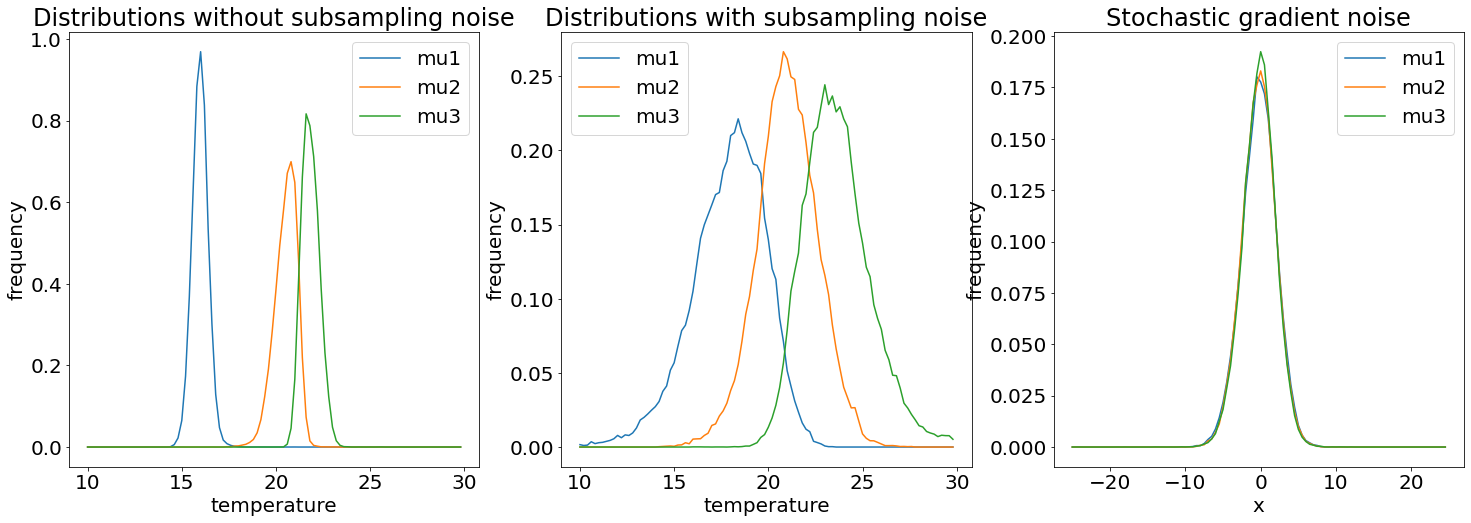

Mean values: [16.071489973918748, 20.610324449910976, 21.93529458376393]
Standard deviations: [0.43108716753787923, 0.5872640180940025, 0.5056594179690357]


Mean values: [15.223368704959942, 18.49309002648568, 22.208768068003472]
Standard deviations: [1.3955823360085966, 1.6337109253210391, 1.4709580101775472]


Mean values: [-0.011821744784245016, 0.013050355014950455, -0.0011978535842098613]
Standard deviations: [2.300204192739004, 2.3217025016081503, 2.290836053950858]


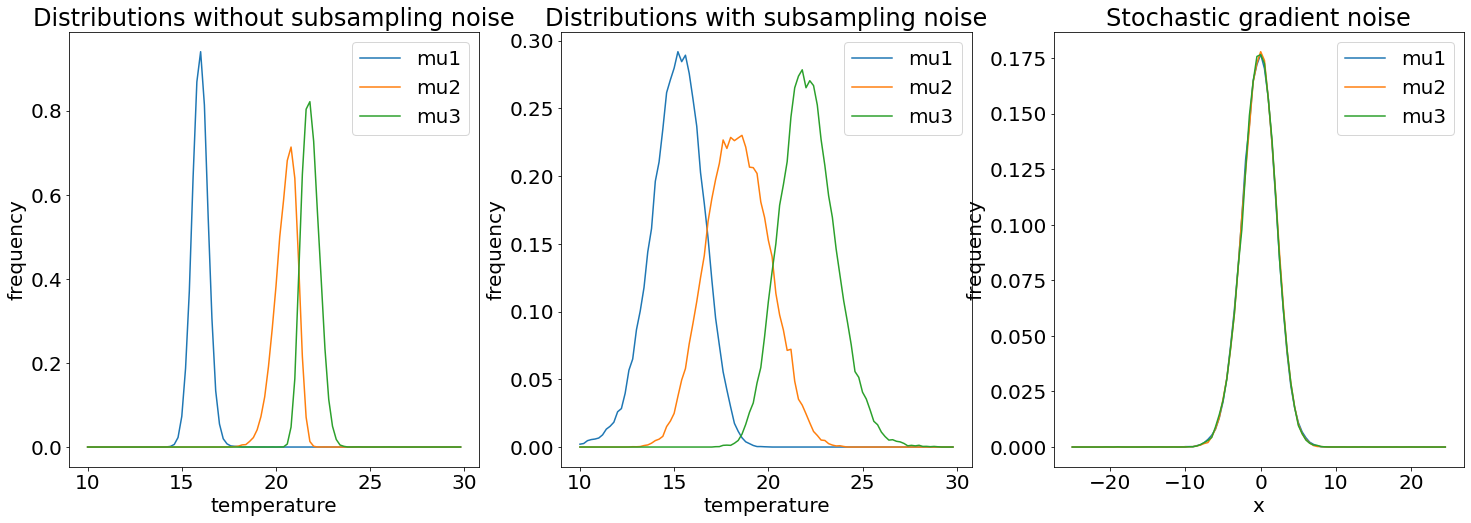

In [8]:
a,b,c = 0,0,0
for s in [100000]:
    for l in [0.1]:
        for i in [1, 5, 10, 20]:       
            for j in [15]:
                
                steps = s
                lr = l
                q00 = j
                q10 = j
                q20 = j

                y = np.random.choice(Y,i,replace=False) # subset for SGD

                Q1 = np.array(run_sim(y,0,0,0,q00,q10,q20,lr,steps)[0])[:,:,0]
                Q2 = np.array(run_sim(Y,a,b,c,q00,q10,q20,lr,steps)[0])[:,:,0]

                # with noise (SGD) no noise if y=Y
                f1_1 = run_sim(y,0,0,0,q00,q10,q20,lr,steps)[1]
                f2_1 = run_sim(y,0,0,0,q00,q10,q20,lr,steps)[2]
                f3_1 = run_sim(y,0,0,0,q00,q10,q20,lr,steps)[3]

                # no noise (GD)  cyz a,b,c=0
                f1_2 = run_sim(Y,a,b,c,q00,q10,q20,lr,steps)[1]
                f2_2 = run_sim(Y,a,b,c,q00,q10,q20,lr,steps)[2]
                f3_2 = run_sim(Y,a,b,c,q00,q10,q20,lr,steps)[3]



                # no noise
                qq2 = np.sort(Q2,1)

                aa10,bb10 = np.histogram( qq2[:,0] ,range=[10,30],bins=100,density=True)
                aa20,bb20 = np.histogram( qq2[:,1] ,range=[10,30],bins=100,density=True)
                aa30,bb30 = np.histogram( qq2[:,2] ,range=[10,30],bins=100,density=True)

                #print("Number of samples: ", i)
                
                fig = plt.figure(figsize=[25,8])
                plt.subplot(1,3,1)
                plt.plot(bb10[:-1],aa10,label='mu1')
                plt.plot(bb20[:-1],aa20,label='mu2')
                plt.plot(bb30[:-1],aa30,label='mu3')
                plt.legend()
                plt.xlabel('temperature')
                plt.ylabel('frequency')
                plt.title('Distributions without subsampling noise')
                    
                print(f'Mean values: {[np.mean(qq2[:,0]), np.mean(qq2[:,1]), np.mean(qq2[:,2])]}')
                print(f'Standard deviations: {[np.std(qq2[:,0]), np.std(qq2[:,1]), np.std(qq2[:,2])]}')
                print("\n")

                # with noise
                qq1 = np.sort(Q1,1)

                aa1,bb1 = np.histogram( qq1[:,0] ,range=[10,30],bins=100,density=True)
                aa2,bb2 = np.histogram( qq1[:,1] ,range=[10,30],bins=100,density=True)
                aa3,bb3 = np.histogram( qq1[:,2] ,range=[10,30],bins=100,density=True)


                plt.subplot(1,3,2)
                plt.plot(bb1[:-1],aa1,label='mu1')
                plt.plot(bb2[:-1],aa2,label='mu2')
                plt.plot(bb3[:-1],aa3,label='mu3')
                plt.legend()
                plt.xlabel('temperature')
                plt.ylabel('frequency')
                plt.title('Distributions with subsampling noise')

                print(f'Mean values: {[np.mean(qq1[:,0]), np.mean(qq1[:,1]), np.mean(qq1[:,2])]}')
                print(f'Standard deviations: {[np.std(qq1[:,0]), np.std(qq1[:,1]), np.std(qq1[:,2])]}')
                print("\n")


                ## distribution of noise
                plt.subplot(1,3,3)
                noise1 = np.array([f1_2]) - np.array([f1_1])
                noise2 = np.array([f2_2]) - np.array([f2_1])
                noise3 = np.array([f3_2]) - np.array([f3_1])
                aa11,bb11 = np.histogram(noise1, range=[-25,25], bins=100,density=True)
                aa22,bb22 = np.histogram(noise2, range=[-25,25], bins=100,density=True)
                aa33,bb33 = np.histogram(noise3, range=[-25,25], bins=100,density=True)
                plt.plot(bb11[:-1],aa11,label='mu1')
                plt.plot(bb22[:-1],aa22,label='mu2')
                plt.plot(bb33[:-1],aa33,label='mu3')
                plt.legend()
                plt.xlabel('x')
                plt.ylabel('frequency')
                plt.title("Stochastic gradient noise")
                
                
                print(f'Mean values: {[np.mean(noise1), np.mean(noise2), np.mean(noise3)]}')
                print(f'Standard deviations: {[np.std(noise1), np.std(noise2), np.std(noise3)]}')

                plt.show()
        

In [9]:
#######################################################
########   ADDING GRADIENT NOISE         ##############
#######################################################


import random

## storage for error vectors
error_noise_m1 = np.array([]); error_noise_m2 = np.array([]); error_noise_m3 = np.array([])

error_no_noise_m1 = np.array([]); error_no_noise_m2 = np.array([]); error_no_noise_m3 = np.array([])

## the exact values of the unknown parameters 
exact_temp_m1 = np.array([16.1]); exact_temp_m2 = np.array([20]); exact_temp_m3 = np.array([22.2])

for i in range(100):
    a,b,c = np.random.normal(0,1,3)
    for s in [100000]: 
        for l in [0.1]:
                    for j in [15]:

                        steps = s
                        lr = l
                        q00 = j
                        q10 = j
                        q20 = j

                       # y = np.random.choice(Y,i,replace=False) # subset for SGD
                        y = Y
                        Q1 = np.array(run_sim(y,0,0,0,q00,q10,q20,lr,steps)[0])[:,:,0]
                        Q2 = np.array(run_sim(Y,a,b,c,q00,q10,q20,lr,steps)[0])[:,:,0]

                        # no noise
                        qq2 = np.sort(Q1,1)

                        aa10,bb10 = np.histogram( qq2[:,0] ,range=[10,30],bins=100,density=True)
                        aa20,bb20 = np.histogram( qq2[:,1] ,range=[10,30],bins=100,density=True)
                        aa30,bb30 = np.histogram( qq2[:,2] ,range=[10,30],bins=100,density=True)
                         
                        err_no_noise_m1 = abs(np.mean(qq2[:,0])-exact_temp_m1)
                        err_no_noise_m2 = abs(np.mean(qq2[:,1])-exact_temp_m2)
                        err_no_noise_m3 = abs(np.mean(qq2[:,2])-exact_temp_m3)
                        
                        error_no_noise_m1 = np.append(error_no_noise_m1, err_no_noise_m1)
                        error_no_noise_m2 = np.append(error_no_noise_m2, err_no_noise_m2)
                        error_no_noise_m3 = np.append(error_no_noise_m3, err_no_noise_m3)
                        
                        # with noise
                        qq1 = np.sort(Q2,1)

                        aa1,bb1 = np.histogram( qq1[:,0] ,range=[10,30],bins=100,density=True)
                        aa2,bb2 = np.histogram( qq1[:,1] ,range=[10,30],bins=100,density=True)
                        aa3,bb3 = np.histogram( qq1[:,2] ,range=[10,30],bins=100,density=True)

                        err_noise_m1 = abs(np.mean(qq1[:,0])-exact_temp_m1)
                        err_noise_m2 = abs(np.mean(qq1[:,1])-exact_temp_m2)
                        err_noise_m3 = abs(np.mean(qq1[:,2])-exact_temp_m3)
                        
                        error_noise_m1 = np.append(error_noise_m1, err_noise_m1)
                        error_noise_m2 = np.append(error_noise_m2, err_noise_m2)
                        error_noise_m3 = np.append(error_noise_m3, err_noise_m3)
                      

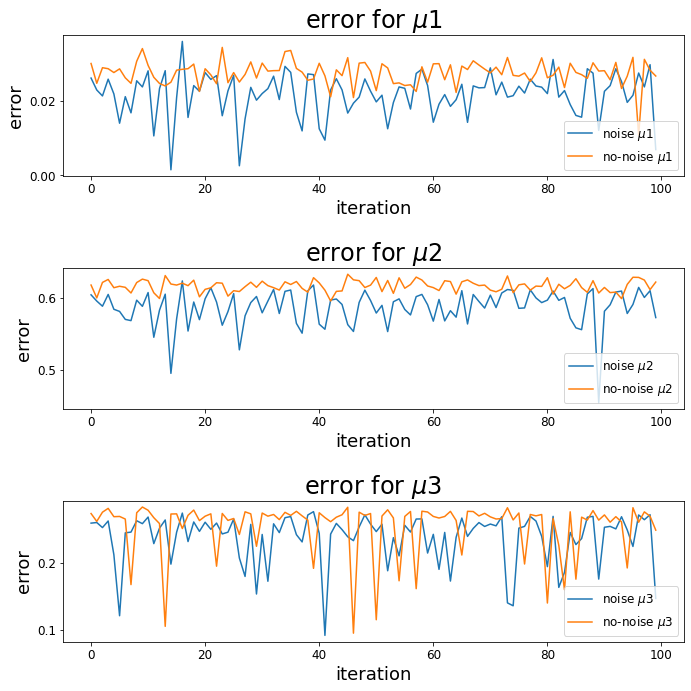

In [10]:
fig = plt.figure(figsize=(10,10))

ax1 = fig.add_subplot(311)
ax1.plot(range(100), error_noise_m1, label = r'noise $\mu1$')
ax1.plot(range(100), error_no_noise_m1, label = r'no-noise $\mu1$')
ax1.set_xlabel('iteration', fontsize=18)  # Add an x-label to the axes.
ax1.set_ylabel('error', fontsize=18)
ax1.set_title(r'error for $\mu 1$')
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
ax1.legend(loc='lower right', fontsize = 12)


ax2 = fig.add_subplot(312)
ax2.plot(range(100), error_noise_m2, label = r'noise $\mu2$')
ax2.plot(range(100), error_no_noise_m2, label = r'no-noise $\mu2$')
ax2.set_xlabel('iteration', fontsize=18)  # Add an x-label to the axes.
ax2.set_ylabel('error', fontsize=18)
ax2.set_title(r'error for $\mu 2$')
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
ax2.legend(loc='lower right', fontsize = 12)


ax3 = fig.add_subplot(313)
ax3.plot(range(100), error_noise_m3, label = r'noise $\mu3$')
ax3.plot(range(100), error_no_noise_m3, label = r'no-noise $\mu3$')
ax3.set_xlabel('iteration', fontsize=18)  # Add an x-label to the axes.
ax3.set_ylabel('error', fontsize=18)
ax3.set_title(r'error for $\mu 3$')
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
ax3.legend(loc='lower right', fontsize = 12)
plt.tight_layout() 

plt.show()

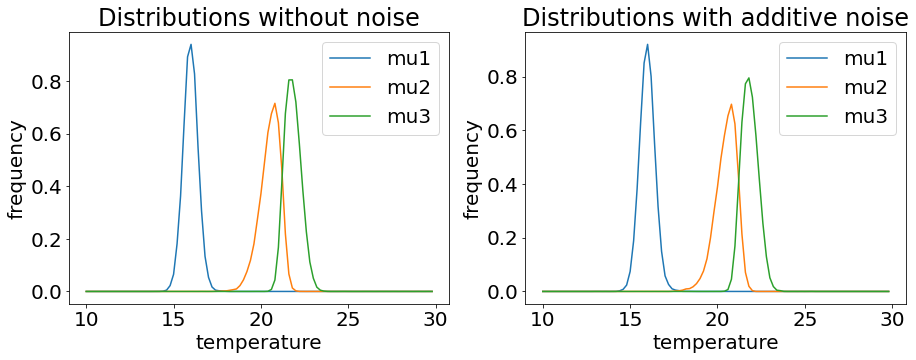

In [16]:
##############################################
####### ADDITIVE NOISE DISTRIBUTION ##########

import random
a,b,c = np.random.normal(0,1,3)

for s in [100000]: 
    for l in [0.1]:
                for j in [15]:
        
                    steps = s
                    lr = l
                    q00 = j
                    q10 = j
                    q20 = j

                   # y = np.random.choice(Y,i,replace=False) # subset for SGD
                    y = Y
                    Q1 = np.array(run_sim(y,0,0,0,q00,q10,q20,lr,steps)[0])[:,:,0]
                    Q2 = np.array(run_sim(Y,a,b,c,q00,q10,q20,lr,steps)[0])[:,:,0]

                    # with no noise xyz a=b=c=0
                    f1_1 = run_sim(y,0,0,0,q00,q10,q20,lr,steps)[1]
                    f2_1 = run_sim(y,0,0,0,q00,q10,q20,lr,steps)[2]
                    f3_1 = run_sim(y,0,0,0,q00,q10,q20,lr,steps)[3]

                    # with additive noise (GD)  cyz a,b,c != 0
                    f1_2 = run_sim(Y,a,b,c,q00,q10,q20,lr,steps)[1]
                    f2_2 = run_sim(Y,a,b,c,q00,q10,q20,lr,steps)[2]
                    f3_2 = run_sim(Y,a,b,c,q00,q10,q20,lr,steps)[3]



                    # no noise
                    qq2 = np.sort(Q1,1)

                    aa10,bb10 = np.histogram( qq2[:,0] ,range=[10,30],bins=100,density=True)
                    aa20,bb20 = np.histogram( qq2[:,1] ,range=[10,30],bins=100,density=True)
                    aa30,bb30 = np.histogram( qq2[:,2] ,range=[10,30],bins=100,density=True)

                    #print("Number of samples: ", i)

                    fig = plt.figure(figsize=[15,5])
                    plt.subplot(1,2,1)
                    plt.plot(bb10[:-1],aa10,label='mu1')
                    plt.plot(bb20[:-1],aa20,label='mu2')
                    plt.plot(bb30[:-1],aa30,label='mu3')
                    plt.legend()
                    plt.xlabel('temperature')
                    plt.ylabel('frequency')
                    plt.title('Distributions without noise')


                    # with noise
                    qq1 = np.sort(Q2,1)

                    aa1,bb1 = np.histogram( qq1[:,0] ,range=[10,30],bins=100,density=True)
                    aa2,bb2 = np.histogram( qq1[:,1] ,range=[10,30],bins=100,density=True)
                    aa3,bb3 = np.histogram( qq1[:,2] ,range=[10,30],bins=100,density=True)


                    plt.subplot(1,2,2)
                    plt.plot(bb1[:-1],aa1,label='mu1')
                    plt.plot(bb2[:-1],aa2,label='mu2')
                    plt.plot(bb3[:-1],aa3,label='mu3')
                    plt.legend()
                    plt.xlabel('temperature')
                    plt.ylabel('frequency')
                    plt.title('Distributions with additive noise')